# Injuries and EDA
The notebook is named 'EDA,' but it also will fetch the injury report from the api and filter injured players from the dataset. We also will have the option to manually remove players is their injury status is uncertain. The mins_proj and mins_share variables will be adjusted to account for the removed players.<br>

Then, finally, we will get summary statistics and histograms to check if our data makes sense.

In [44]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import requests
import sqlite3
import re
import matplotlib.pyplot as plt

# Get the parent directory where config.py is located
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

API_KEY = None
API_HOST = None

In [45]:
from config import API_KEY, API_HOST

headers = {
    "x-rapidapi-key": API_KEY,
    "x-rapidapi-host": API_HOST
}

In [46]:
today = (datetime.now()).strftime('%Y%m%d')

In [47]:
main_df = pd.read_csv('ready_for_injuries.csv')

In [48]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Dejounte Murray,20250208_NO@SAC,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.802673,3500,2025-02-08,PG,True,False,False,False,False
1,Shake Milton,20250208_IND@LAL,28008397499,14,LAL,ORL,3.866667,2.200000,0.666667,1.800000,...,14.466667,10.413917,3700,2025-02-08,SG,True,False,False,False,False
2,Steven Adams,20250208_HOU@DAL,28018735349,11,HOU,TOR,3.733333,1.133333,0.000000,2.066667,...,15.533333,10.911220,4300,2025-02-08,C,False,False,False,False,True
3,Gary Payton II,20250208_GS@CHI,28038983399,10,GS,IND,4.333333,1.400000,0.466667,2.333333,...,13.733333,10.965205,3700,2025-02-08,PG,True,True,False,False,False
4,Buddy Hield,20250208_GS@CHI,28038998249,10,GS,GS,9.933333,2.333333,2.266667,3.800000,...,25.133333,20.067389,4800,2025-02-08,SF,True,True,False,False,False


In [49]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longName    375 non-null    object 
 1   game_id     375 non-null    object 
 2   player_id   375 non-null    int64  
 3   team_id     375 non-null    int64  
 4   team        375 non-null    object 
 5   teamAbv     375 non-null    object 
 6   fga         375 non-null    float64
 7   ast         375 non-null    float64
 8   tptfgm      375 non-null    float64
 9   fgm         375 non-null    float64
 10  fta         375 non-null    float64
 11  tptfga      375 non-null    float64
 12  OffReb      375 non-null    float64
 13  ftm         375 non-null    float64
 14  blk         375 non-null    float64
 15  DefReb      375 non-null    float64
 16  plusMinus   375 non-null    float64
 17  stl         375 non-null    float64
 18  pts         375 non-null    float64
 19  fouls       375 non-null    f

In [50]:
#Changing player_id to string
main_df["player_id"] = main_df["player_id"].astype(str)

In [51]:
main_df['player_id'].nunique()

375

In [52]:
#Remove teams that aren't in slate
#There's nothing programmatic about this. We just check the full NBA schedule against the FD or DK slate we're playing.
teams_to_remove = []
remove_teams = int(input("How many teams do you want to remove from the slate?"))
for i in range(0, remove_teams):
    teams_to_remove.append(input("Remove team."))

How many teams do you want to remove from the slate? 4
Remove team. HOU
Remove team. DAL
Remove team. LAL
Remove team. IND


In [53]:
main_df = main_df[~main_df['team'].isin(teams_to_remove)]

In [54]:
player_ids = list(main_df['player_id'])

# Getting injury reports
We call the API to get injury information and availability status of every player in the current day's slate.

In [55]:
col_heads = ['name', 'player_id', 'injury', 'inj_date', 'status', 'return_date', 'last_game']
rows = []
for id in player_ids:
    
    url = f"https://tank01-fantasy-stats.p.rapidapi.com/getNBAPlayerInfo?playerID={id}"
        
    headers = {
        "x-rapidapi-key": "3103a75392msh7bce7c32fde122cp134393jsn4d42ed6d08a8",
        "x-rapidapi-host": "tank01-fantasy-stats.p.rapidapi.com"
    }
    
    response = requests.get(url, headers=headers)
    result = response.json()
    
    if 'body' in result and result['body']:  
        injury_data = result['body'].get('injury', {})
        if any(value != '' for value in injury_data.values()):  # Check if injury dict has data
            rows.append([
                result['body']['longName'],
                result['body']['playerID'],
                injury_data.get('description', ''),
                injury_data.get('injDate', ''),
                injury_data.get('designation', ''),
                injury_data.get('injReturnDate', ''),
                result['body'].get('lastGamePlayed', '')
            ])

injury_df = pd.DataFrame(rows, columns = col_heads)

In [56]:
injury_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Dejounte Murray,28008317499,Jan 31: Shams Charania of ESPNMurray suffered ...,,Out,20251001,20250131_BOS@NO
1,Matisse Thybulle,28108517499,Feb 7: Thybulle (ankle) has been ruled out for...,20240805,Out,20250210,20240329_POR@MIA
2,Damion Lee,28108923399,,20240805,,,20250207_UTA@PHO
3,Russell Westbrook,28116619932,Feb 3: Head coach Mike Malone said Monday that...,,Out,20250220,20250131_DEN@PHI
4,Torrey Craig,28118432369,Feb 8: Craig is out Saturday's game versus the...,,Out,20250210,20241230_CHI@CHA
...,...,...,...,...,...,...,...
117,Taylor Hendricks,949347211869,Nov 6: Hendricks underwent surgery on his brok...,20240805,Out,20251001,20241028_UTA@DAL
118,Alex Sarr,949541715989,Feb 6: Sarr (ankle) has been ruled out for Fri...,,Out,20250208,20250127_WAS@DAL
119,Dalen Terry,94954916527,Feb 7: Terry (knee) is listed as questionable ...,,Day-To-Day,20250208,20250202_CHI@DET
120,Brice Sensabaugh,949747621869,,20240805,,,20250207_UTA@PHO


In [57]:
len(injury_df)

122

In [58]:
#Filtering injury_df for players who are out.
out_df = injury_df[injury_df['status'] == 'Out']

In [59]:
out_players = list(out_df['player_id'])

In [60]:
#Starting a dataframe of players who aren't playing and can't be used in lineups
removed_df = main_df[main_df['player_id'].isin(out_players)]

In [61]:
#Taking those players out of main_df
main_df = main_df[~main_df['player_id'].isin(out_players)]

In [62]:
removed_df

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Dejounte Murray,20250208_NO@SAC,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.802673,3500,2025-02-08,PG,True,False,False,False,False
14,Matisse Thybulle,20250208_POR@MIN,28108517499,25,POR,PHO,5.066667,1.733333,0.933333,1.933333,...,21.333333,14.834846,3500,2025-02-08,SF,False,False,True,False,False
16,Russell Westbrook,20250208_DEN@PHO,28116619932,8,DEN,LAC,11.266667,5.800000,1.266667,5.800000,...,30.133333,24.098634,6100,2025-02-08,PG,True,False,False,False,False
19,Torrey Craig,20250208_BOS@NY,28118432369,2,BOS,MIN,4.333333,0.733333,1.400000,2.066667,...,13.733333,10.782400,3500,2025-02-08,SF,False,False,True,False,False
20,Collin Sexton,20250208_UTA@LAC,28118882869,29,UTA,UTA,14.866667,4.733333,1.866667,6.933333,...,28.933333,17.451134,6100,2025-02-08,SG,True,True,False,False,False
40,Vlatko Cancar,20250208_DEN@PHO,28188530069,8,DEN,NO,1.750000,0.000000,0.250000,1.000000,...,8.500000,6.797734,3500,2025-02-08,SF,False,False,True,False,False
44,Clint Capela,20250208_ATL@WAS,28218011729,1,ATL,UTA,6.466667,1.066667,0.000000,3.800000,...,21.533333,13.240171,5100,2025-02-08,C,False,False,False,False,True
70,Desmond Bane,20250208_OKC@MEM,28328616399,15,MEM,MIL,15.800000,6.533333,2.333333,8.600000,...,33.266667,24.391039,7400,2025-02-08,SG,False,True,True,False,False
96,Julius Randle,20250208_POR@MIN,28438011729,18,MIN,CLE,13.266667,4.400000,0.666667,5.933333,...,31.200000,25.630669,6800,2025-02-08,PF,False,False,False,True,False
117,Jrue Holiday,20250208_BOS@NY,28518491632,2,BOS,TOR,7.800000,3.400000,1.466667,3.066667,...,29.466667,23.135053,5000,2025-02-08,PG,True,True,False,False,False


In [63]:
len(main_df)

269

In [64]:
out_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Dejounte Murray,28008317499,Jan 31: Shams Charania of ESPNMurray suffered ...,,Out,20251001,20250131_BOS@NO
1,Matisse Thybulle,28108517499,Feb 7: Thybulle (ankle) has been ruled out for...,20240805,Out,20250210,20240329_POR@MIA
3,Russell Westbrook,28116619932,Feb 3: Head coach Mike Malone said Monday that...,,Out,20250220,20250131_DEN@PHI
4,Torrey Craig,28118432369,Feb 8: Craig is out Saturday's game versus the...,,Out,20250210,20241230_CHI@CHA
5,Collin Sexton,28118882869,Feb 4: The Jazz announced Tuesday that Sexton ...,20240805,Out,20250212,20250203_IND@UTA
11,Vlatko Cancar,28188530069,Dec 4: Cancar (knee) will be re-evaluated in 8...,,Out,20250220,20241119_DEN@MEM
12,Clint Capela,28218011729,Feb 6: Capela (personal) is out for Friday's g...,,Out,20250208,20250127_ATL@MIN
19,Desmond Bane,28328616399,Feb 7: Bane (ankle) is listed as questionable ...,20240805,Out,20250208,20250202_MEM@MIL
27,Julius Randle,28438011729,Feb 5: Minnesota announced Wednesday that Rand...,20240805,Out,20250221,20250130_MIN@UTA
34,Jrue Holiday,28518491632,Feb 7: Holiday (shoulder) won't play in Saturd...,20240805,Out,20250210,20250204_BOS@CLE


In [65]:
#Starting a game-time-decision dataframe
gtd_df = injury_df[injury_df['status'] == 'Day-To-Day'].reset_index(drop = True)

In [66]:
len(gtd_df)

38

In [67]:
gtd_df

,name,player_id,injury,inj_date,status,return_date,last_game
0,Kelly Olynyk,28188235349,Feb 6: The Raptors traded Olynyk to the Pelica...,,Day-To-Day,20250208,20250205_MEM@TOR
1,Mike Conley,28236562792,Feb 7: Conley (finger) is listed as questionab...,,Day-To-Day,20250208,20250206_HOU@MIN
2,Zach Collins,28268546399,Feb 6: Head coach Billy Donovan said Tuesday t...,20240805,Day-To-Day,20250208,20250201_MIA@SA
3,Karl-Anthony Towns,28278119129,Feb 7: Towns (knee) has been listed as probabl...,,Day-To-Day,20250208,20250204_NY@TOR
4,Bruce Brown,28328326789,Feb 6: The Raptors traded Brown to the Pelican...,,Day-To-Day,20250208,20250205_MEM@TOR
5,Kevin Durant,28336662792,Feb 8: Durant (ankle) has been ruled out for F...,,Day-To-Day,20250208,20250203_PHO@POR
6,Luguentz Dort,28358802047,Feb 8: Dort has been ruled out for Friday's ga...,,Day-To-Day,20250208,20250205_PHO@OKC
7,Anthony Gill,28358980482,Feb 8: Gill has been ruled out for the rest of...,,Day-To-Day,20250208,20250207_CLE@WAS
8,Lonzo Ball,28368516399,Feb 7: Ball (illness) has been listed as quest...,20240805,Day-To-Day,20250208,20250204_MIA@CHI
9,Vasilije Micic,28418011729,Feb 8: Micic (recently traded) is not with the...,,Day-To-Day,20250208,20250203_WAS@CHA


In [68]:
#Here, we make our judgment based on the injury reports, and decide whether or not to filter players out of the lineup
remove_dtd_list = []
remove_dtd = input("Do you want to manually remove any players from the player list?").lower()
while remove_dtd == 'y':
    player_to_remove = int(input("Enter the index number of the player to remove:"))
    remove_dtd_list.append(gtd_df.iloc[player_to_remove, 1])
    remove_dtd = input("Do you want to manually remove another player from the player list?").lower()
    

Do you want to manually remove any players from the player list? y
Enter the index number of the player to remove: 0
Do you want to manually remove another player from the player list? y
Enter the index number of the player to remove: 4
Do you want to manually remove another player from the player list? n


In [69]:
print(remove_dtd_list)

['28188235349', '28328326789']


In [70]:
gtd_df = main_df[main_df['player_id'].isin(remove_dtd_list)]

In [71]:
#Taking manually removed players out of main_df
main_df = main_df[~main_df['player_id'].isin(remove_dtd_list)]

In [72]:
#Concatenating so we have one dataframe of all removed players
removed_df = pd.concat([removed_df, gtd_df], ignore_index = True)

In [73]:
len(main_df)

267

In [74]:
removed_df.head(10)

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
0,Dejounte Murray,20250208_NO@SAC,28008317499,19,NO,MIN,15.600000,7.200000,1.933333,6.600000,...,31.133333,20.802673,3500,2025-02-08,PG,True,False,False,False,False
1,Matisse Thybulle,20250208_POR@MIN,28108517499,25,POR,PHO,5.066667,1.733333,0.933333,1.933333,...,21.333333,14.834846,3500,2025-02-08,SF,False,False,True,False,False
2,Russell Westbrook,20250208_DEN@PHO,28116619932,8,DEN,LAC,11.266667,5.800000,1.266667,5.800000,...,30.133333,24.098634,6100,2025-02-08,PG,True,False,False,False,False
3,Torrey Craig,20250208_BOS@NY,28118432369,2,BOS,MIN,4.333333,0.733333,1.400000,2.066667,...,13.733333,10.782400,3500,2025-02-08,SF,False,False,True,False,False
4,Collin Sexton,20250208_UTA@LAC,28118882869,29,UTA,UTA,14.866667,4.733333,1.866667,6.933333,...,28.933333,17.451134,6100,2025-02-08,SG,True,True,False,False,False
5,Vlatko Cancar,20250208_DEN@PHO,28188530069,8,DEN,NO,1.750000,0.000000,0.250000,1.000000,...,8.500000,6.797734,3500,2025-02-08,SF,False,False,True,False,False
6,Clint Capela,20250208_ATL@WAS,28218011729,1,ATL,UTA,6.466667,1.066667,0.000000,3.800000,...,21.533333,13.240171,5100,2025-02-08,C,False,False,False,False,True
7,Desmond Bane,20250208_OKC@MEM,28328616399,15,MEM,MIL,15.800000,6.533333,2.333333,8.600000,...,33.266667,24.391039,7400,2025-02-08,SG,False,True,True,False,False
8,Julius Randle,20250208_POR@MIN,28438011729,18,MIN,CLE,13.266667,4.400000,0.666667,5.933333,...,31.200000,25.630669,6800,2025-02-08,PF,False,False,False,True,False
9,Jrue Holiday,20250208_BOS@NY,28518491632,2,BOS,TOR,7.800000,3.400000,1.466667,3.066667,...,29.466667,23.135053,5000,2025-02-08,PG,True,True,False,False,False


In [75]:
main_df[(main_df['team'] == 'BOS') & (main_df['prim_pos'] == 'PG')][['longName', 'mins_proj', 'mins_share']]

,longName,mins_proj,mins_share
8,Payton Pritchard,20.989041,0.087454
318,JD Davison,3.991058,0.016629


# Adjusting minutes variables with players out

In [76]:
#First let's see summary statistics before injury adjustments
main_df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
team_id,267.0,17.551,8.972,1.0,10.000,20.000,25.000,30.000
fga,267.0,7.025,5.285,0.0,2.800,5.923,9.933,22.467
ast,267.0,2.093,1.982,0.0,0.733,1.400,3.000,11.600
tptfgm,267.0,1.067,0.955,0.0,0.267,0.800,1.667,4.067
fgm,267.0,3.251,2.598,0.0,1.167,2.533,4.833,12.400
fta,267.0,1.717,1.837,0.0,0.500,1.067,2.200,10.200
tptfga,267.0,3.000,2.444,0.0,0.867,2.533,4.600,11.867
OffReb,267.0,0.942,0.871,0.0,0.333,0.667,1.267,5.533
ftm,267.0,1.348,1.531,0.0,0.333,0.800,1.733,9.533
blk,267.0,0.409,0.459,0.0,0.083,0.267,0.600,3.800


# Adjusting variables
We take each removed player's primary position and calculate the sum of lost mins_proj and mins_share per team per position. Then we proportionately add what's been lost to the mins_proj and mins_share values of the remaining players. The more the current mins_proj and mins_share values, the more that gets added.

In [77]:
team_position_loss = removed_df.groupby(["team", "prim_pos"])[["mins_share", "mins_proj"]].sum().reset_index()

for index, row in team_position_loss.iterrows():
    team, pos, lost_mins_share, lost_mins_proj = row["team"], row["prim_pos"], row["mins_share"], row["mins_proj"]
    
    # Get remaining players at the same position
    mask = (main_df["team"] == team) & (main_df["prim_pos"] == pos)
    remaining_players = main_df.loc[mask]
    
    if not remaining_players.empty:
        # Separate scaling for mins_share and mins_proj
        total_existing_share = remaining_players["mins_share"].sum()
        total_existing_proj = remaining_players["mins_proj"].sum()
        
        if total_existing_share > 0:
            # Distribute lost mins_share proportionally
            main_df.loc[mask, "mins_share"] += (
                     (remaining_players["mins_share"] / total_existing_share) * lost_mins_share
                 )
    
        if total_existing_proj > 0:
            # Distribute lost mins_proj proportionally
            main_df.loc[mask, "mins_proj"] += (
                     (remaining_players["mins_proj"] / total_existing_proj) * lost_mins_proj
                 )


In [78]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267 entries, 3 to 374
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   longName    267 non-null    object 
 1   game_id     267 non-null    object 
 2   player_id   267 non-null    object 
 3   team_id     267 non-null    int64  
 4   team        267 non-null    object 
 5   teamAbv     267 non-null    object 
 6   fga         267 non-null    float64
 7   ast         267 non-null    float64
 8   tptfgm      267 non-null    float64
 9   fgm         267 non-null    float64
 10  fta         267 non-null    float64
 11  tptfga      267 non-null    float64
 12  OffReb      267 non-null    float64
 13  ftm         267 non-null    float64
 14  blk         267 non-null    float64
 15  DefReb      267 non-null    float64
 16  plusMinus   267 non-null    float64
 17  stl         267 non-null    float64
 18  pts         267 non-null    float64
 19  fouls       267 non-null    float6

In [79]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
3,Gary Payton II,20250208_GS@CHI,28038983399,10,GS,IND,4.333333,1.400000,0.466667,2.333333,...,13.733333,10.965205,3700,2025-02-08,PG,True,True,False,False,False
4,Buddy Hield,20250208_GS@CHI,28038998249,10,GS,GS,9.933333,2.333333,2.266667,3.800000,...,25.133333,20.067389,4800,2025-02-08,SF,True,True,False,False,False
5,Stephen Curry,20250208_GS@CHI,28046691632,10,GS,MIL,19.600000,5.466667,4.066667,8.000000,...,33.266667,26.561346,8700,2025-02-08,PG,True,False,False,False,False
6,Corey Kispert,20250208_ATL@WAS,28048809869,30,WAS,MIL,9.133333,1.333333,1.733333,4.333333,...,25.866667,18.743961,4400,2025-02-08,SG,False,False,True,False,False
7,Mason Jones,20250208_NO@SAC,28058649047,26,SAC,BOS,2.000000,1.400000,0.300000,0.800000,...,5.500000,4.238921,3500,2025-02-08,SG,False,True,False,False,False


In [80]:
main_df[(main_df['team'] == 'BOS') & (main_df['prim_pos'] == 'PG')][['longName', 'mins_proj', 'mins_share']]

,longName,mins_proj,mins_share
8,Payton Pritchard,40.427817,0.168449
318,JD Davison,7.687334,0.032031


In [81]:
#Summary statistics after adjustments
main_df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
team_id,267.0,17.551,8.972,1.0,10.000,20.000,25.000,30.000
fga,267.0,7.025,5.285,0.0,2.800,5.923,9.933,22.467
ast,267.0,2.093,1.982,0.0,0.733,1.400,3.000,11.600
tptfgm,267.0,1.067,0.955,0.0,0.267,0.800,1.667,4.067
fgm,267.0,3.251,2.598,0.0,1.167,2.533,4.833,12.400
fta,267.0,1.717,1.837,0.0,0.500,1.067,2.200,10.200
tptfga,267.0,3.000,2.444,0.0,0.867,2.533,4.600,11.867
OffReb,267.0,0.942,0.871,0.0,0.333,0.667,1.267,5.533
ftm,267.0,1.348,1.531,0.0,0.333,0.800,1.733,9.533
blk,267.0,0.409,0.459,0.0,0.083,0.267,0.600,3.800


# Histograms

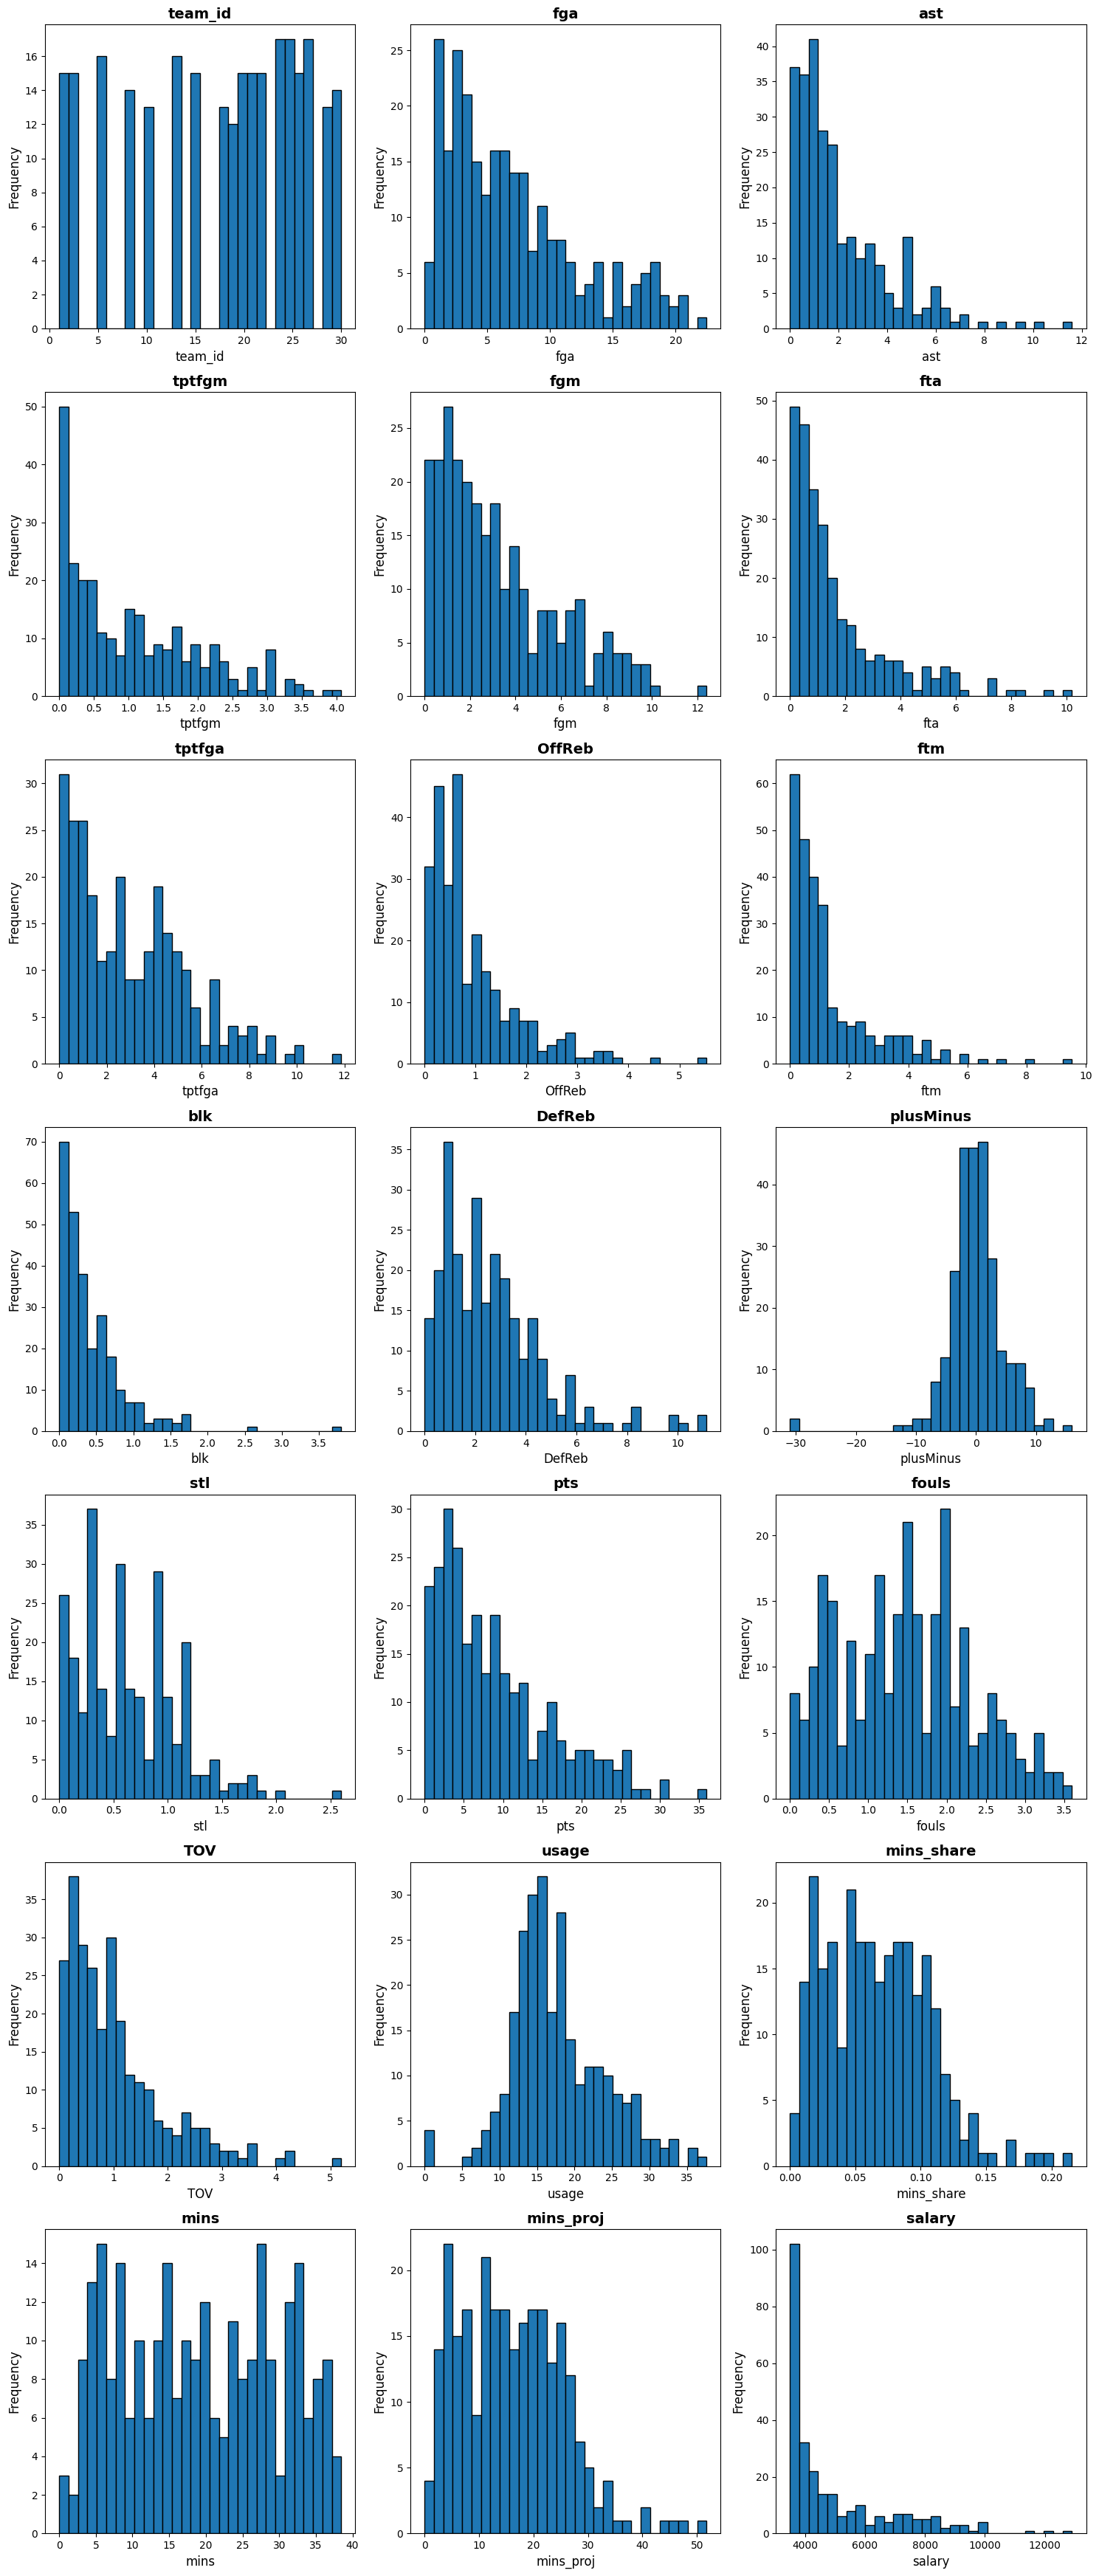

In [82]:
num_features = main_df.select_dtypes(include=['number']).columns
num_cols = 3  # Number of columns in the grid
num_rows = -(-len(num_features) // num_cols)  # Ceiling division to get the number of rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figure size dynamically
axes = axes.flatten()  # Flatten the 2D array of subplots for easy indexing

for idx, col_name in enumerate(num_features):
    ax = axes[idx]  # Select the appropriate subplot
    ax.hist(main_df[col_name].dropna(), bins=30, edgecolor='black')

    # Set title and labels with larger font sizes
    ax.set_title(f"{col_name}", fontsize=14, fontweight='bold')
    ax.set_xlabel(col_name, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

# Hide any unused subplots (in case total features are not a multiple of `num_cols`)
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [83]:
main_df.head()

,longName,game_id,player_id,team_id,team,teamAbv,fga,ast,tptfgm,fgm,...,mins,mins_proj,salary,date,prim_pos,PG,SG,SF,PF,C
3,Gary Payton II,20250208_GS@CHI,28038983399,10,GS,IND,4.333333,1.400000,0.466667,2.333333,...,13.733333,10.965205,3700,2025-02-08,PG,True,True,False,False,False
4,Buddy Hield,20250208_GS@CHI,28038998249,10,GS,GS,9.933333,2.333333,2.266667,3.800000,...,25.133333,20.067389,4800,2025-02-08,SF,True,True,False,False,False
5,Stephen Curry,20250208_GS@CHI,28046691632,10,GS,MIL,19.600000,5.466667,4.066667,8.000000,...,33.266667,26.561346,8700,2025-02-08,PG,True,False,False,False,False
6,Corey Kispert,20250208_ATL@WAS,28048809869,30,WAS,MIL,9.133333,1.333333,1.733333,4.333333,...,25.866667,18.743961,4400,2025-02-08,SG,False,False,True,False,False
7,Mason Jones,20250208_NO@SAC,28058649047,26,SAC,BOS,2.000000,1.400000,0.300000,0.800000,...,5.500000,4.238921,3500,2025-02-08,SG,False,True,False,False,False


In [84]:
#Writing to csv
main_df.to_csv('ready_for_pred.csv', index = False)